# load file and basic plotting functions

In [2]:
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.stats as stats

def load_file(filename,df_only = False):    
    #### extract information in dictionary ####
    with open('{}'.format(filename)) as csvfile:
            csvreader = csv.reader(csvfile)
            rows =list(csvreader)  # keep only first 2 lines
            # concatenate strings of first 2 rows and split into stuff before and after the =
            inter = (rows[0][0]+rows[1][0]).split(' = ')
            # the "after ="-information is at the beginning of each string except the first
            # we also don't want to split the last string, since it is only an "after ="-information
            sequals = [entry.split(' ',1)[0] for entry in inter[1:-1]]+[inter[-1]]
            # the "before ="-info is at the end of each split, we also add the first "before="
            prequals = [inter[0]]+[entry.split(' ',1)[1] for entry in inter[1:-1]]
            # we make a dictionary out of the information
            header_dict = {prequals[i]:sequals[i] for i in range(len(sequals))}
    ### get a column list with the names of the columns
    column_list = rows[2][:-1]
    ### return a numpy array
    arr = np.array(rows[3:])
    ### return also a pandas dataframe
    df = pd.read_csv(str(filename),skiprows=2,usecols=[i for i in range(len(column_list))])
    df.columns = column_list
    ### polishing some data
    df["A-Tracker X"][0] = 0
    df["B-Tracker X"][0] = 0
    df["System Time"]= (df["System Time"]-df["System Time"][0])/1000
    df["A-Acceleration"] = df["A-Tracker X"].diff()
    df["B-Acceleration"] = df["B-Tracker X"].diff()
    df["A-Acceleration"][0] = 0
    df["B-Acceleration"][0] = 0
    df
    if df_only == True:
        return df
    else:
        return arr, df, header_dict, column_list

def load_files():
    mypath = r'C:\Users\david-bierbrauer\Documents\LabRotation\FroeseUnit\Teams{}'
    import glob
    allfiles = glob.glob(mypath.format("\*\*.csv"))
    df_list = [load_file(r'{}'.format(file),True) for file in allfiles]
    return allfiles, df_list
    


def get_columns(*args):
    columns = [column_list.index(i) for i in args[0]]
    red = array[:,columns]
    return red

def plot_position (difference,objects,shadows,*args):
    args = [arg for arg in args[0]]
    print(args)
    if difference == True:
        plot_differences(objects, shadows, args)
    else:
        plot_agents(objects,shadows,args)
        
def plot_agents(objects,shadows,*args):
    fig = plt.figure(figsize=(30,10))
    ax = fig.add_subplot(111)
    
    colors = ["blue","red","green","yellow"]
    # plotting against system time, we substract the first value to get relative tome to 0
    # reshaping to 1dim array
    system_time = get_columns(["System Time"]).astype(np.float)
    x = np.reshape((system_time - system_time[0])/1000,-1)
    
    
    # get columns requested by args. args is a tuple
    # so we take only the first argument which is our list
    for agent in args[0]:
        co = colors[args[0].index(agent)]
        # get agent positions
        y = np.reshape(get_columns(["{}-Position".format(agent)]).astype(np.int),-1)
        ax.plot(x,y,label='{}-Postion'.format(agent),color= co,linestyle='-',linewidth=4)
        #ax.fill_between(x,y,y+int(header_dict.get("Agent {} width".format(agent))),color=co,linestyle='--')
        
        # plotting the objects. a little overkill,
        # but we take all values from the dictionary, just in case
        if objects==True:
            obj = "Agent {} static object".format(agent)
            yO = np.reshape(np.full((len(x),1),int(header_dict.get("{} position".format(obj)))),-1)
            ax.plot(x,yO,color=co,label='{}-Object'.format(agent),linestyle='--',alpha=0.7,linewidth=4)
            #ax.fill_between(x,yO,yO+int(header_dict.get("{} width".format(obj))),color=co,linestyle='-')
        
        if shadows==True:
            lure = "Agent {} lure".format(agent)
            yS = (y + int(header_dict.get("{} offset".format(lure))))%600
            ax.plot(x,yS,color=co,linestyle=':',alpha=0.2,
                    label='{}-Shadow'.format(agent),linewidth=4)

            
        us = np.reshape(get_columns(["User{}-Static".format(agent)]).astype(bool),-1)
        ax.plot(x[us],y[us],color="black",marker="o", markersize=10,linewidth=0)
        # vibration signal
        haptic1 = np.reshape(get_columns(["{}-Haptic 1".format(agent)]).astype(bool),-1)
        ax.plot(x[haptic1],y[haptic1],color="green",marker="x",
                markersize=10,linewidth=0,label="vibration")
        # whatever this is
        haptic2 = np.reshape(get_columns(["{}-Haptic 2".format(agent)]).astype(bool),-1)
        ax.plot(x[haptic2],y[haptic2],color="yellow",marker="x", markersize=50,linewidth=0)
        # click
        try:
            button = np.reshape(get_columns(["{}-Buttonstate".format(agent)]).astype(bool),-1)
            ax.arrow(x[button][0],y[button][0]+100,0,-70,color=co,width=0.5,head_length=20)
        except:
            print("Player {} did not click".format(agent))
    
    touch = np.reshape(get_columns(["Users Touching"]).astype(bool),-1)
    ax.plot(x[touch],y[touch],color="black",marker="o", markersize=10,linewidth=0,label="Users touching")
    
    ax.legend()
    fig.show()

def plot_differences(objects = True,shadows = True,*args):
    fig = plt.figure(figsize=(30,10))
    ax = fig.add_subplot(111)

    colors = ["blue","red","green","yellow"]
    # plotting against system time, we substract the first value to get relative tome to 0
    # reshaping to 1dim array
    system_time = get_columns(["System Time"]).astype(np.float)
    x = np.reshape((system_time - system_time[0])/1000,-1)

    y1 = (np.reshape(get_columns(["B-Position"]).astype(np.int),-1))%600 -(np.reshape(get_columns(["A-Position"]).astype(np.int),-1))%600
    y = y1
    ax.plot(x,y,label='difference',color= "black",linestyle='-')
    
    if shadows == True:
        yS1 = np.reshape(np.full((len(x),1),150),-1)
        ax.plot(x,yS1,color="red",linestyle=':',alpha=0.3,label='B-Player hits A-Shadow')

        yS2 = np.reshape(np.full((len(x),1),-150),-1)
        ax.plot(x,yS2,color="blue",linestyle=':',alpha=0.3,label='A-Player hits B-Shadow')

    hit = np.reshape(np.full((len(x),1),0),-1)
    ax.plot(x,hit,color="black",linestyle=':',alpha=0.3,label='Players meet')


    # get columns requested by args. args is a tuple
    # so we take only the first argument which is our list
    for agent in args[0]:
        co = colors[args[0].index(agent)]
        # vibration signal
        if objects == True:
            haptic1 = np.reshape(get_columns(["{}-Haptic 1".format(agent)]).astype(bool),-1)
            ax.plot(x[haptic1],y[haptic1],color= co,marker="x",
                    markersize=10,linewidth=0,label="vibration Player {}".format(agent))
            # whatever this is
            haptic2 = np.reshape(get_columns(["{}-Haptic 2".format(agent)]).astype(bool),-1)
            ax.plot(x[haptic2],y[haptic2],color="yellow",marker="x", markersize=50,linewidth=0)
        # click
        try:
            button = np.reshape(get_columns(["{}-Buttonstate".format(agent)]).astype(bool),-1)
            ax.arrow(x[button][0],y[button][0]+100,0,-70,color=co,width=0.5,head_length=20)
        except:
            print("Player {} did not click".format(agent))

    touch = np.reshape(get_columns(["Users Touching"]).astype(bool),-1)
    ax.plot(x[touch],y[touch],color="black",marker="o", markersize=10,linewidth=0,label="Users feel each other")

    ax.legend()
    fig.show()


# load and plot positions of one file (numpy)

<ipython-input-2-f34f9691cedf>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["A-Tracker X"][0] = 0
<ipython-input-2-f34f9691cedf>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["B-Tracker X"][0] = 0
<ipython-input-2-f34f9691cedf>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["A-Acceleration"][0] = 0
<ipython-input-2-f34f9691cedf>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

['A', 'B']
['A', 'B']


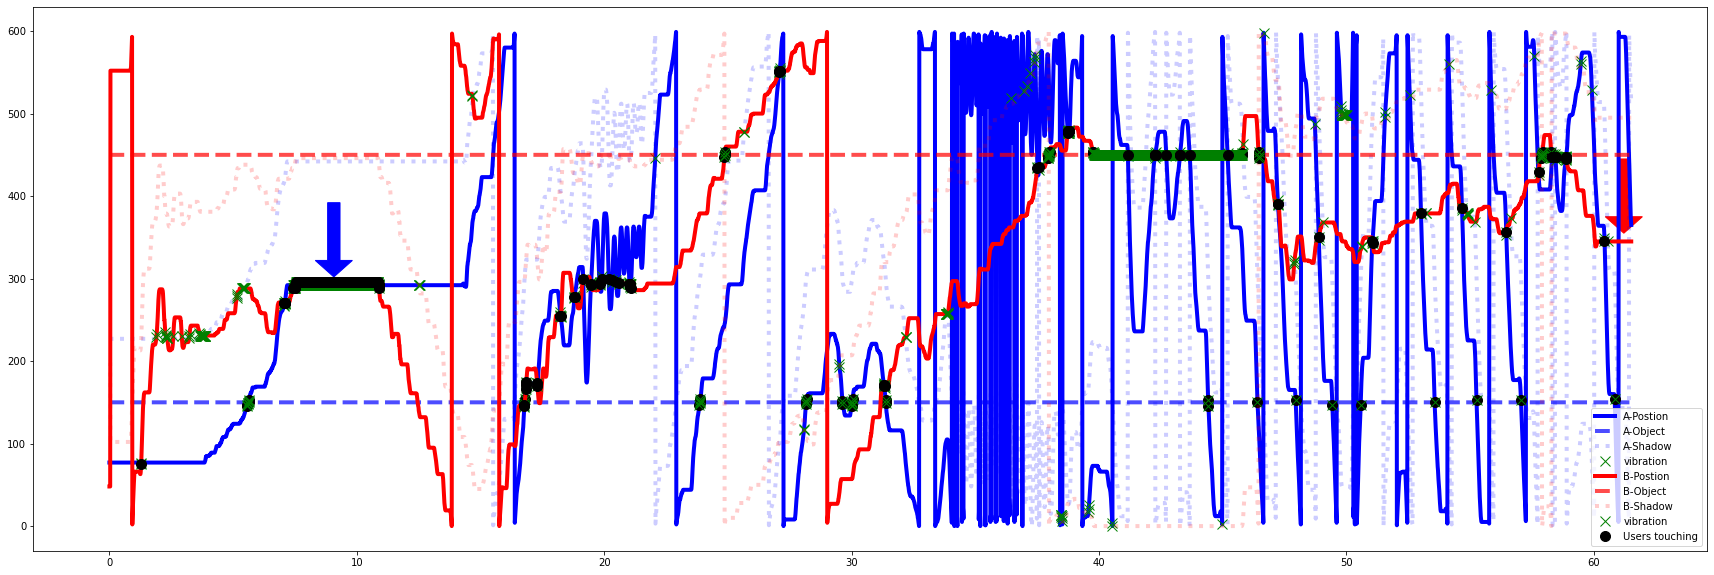

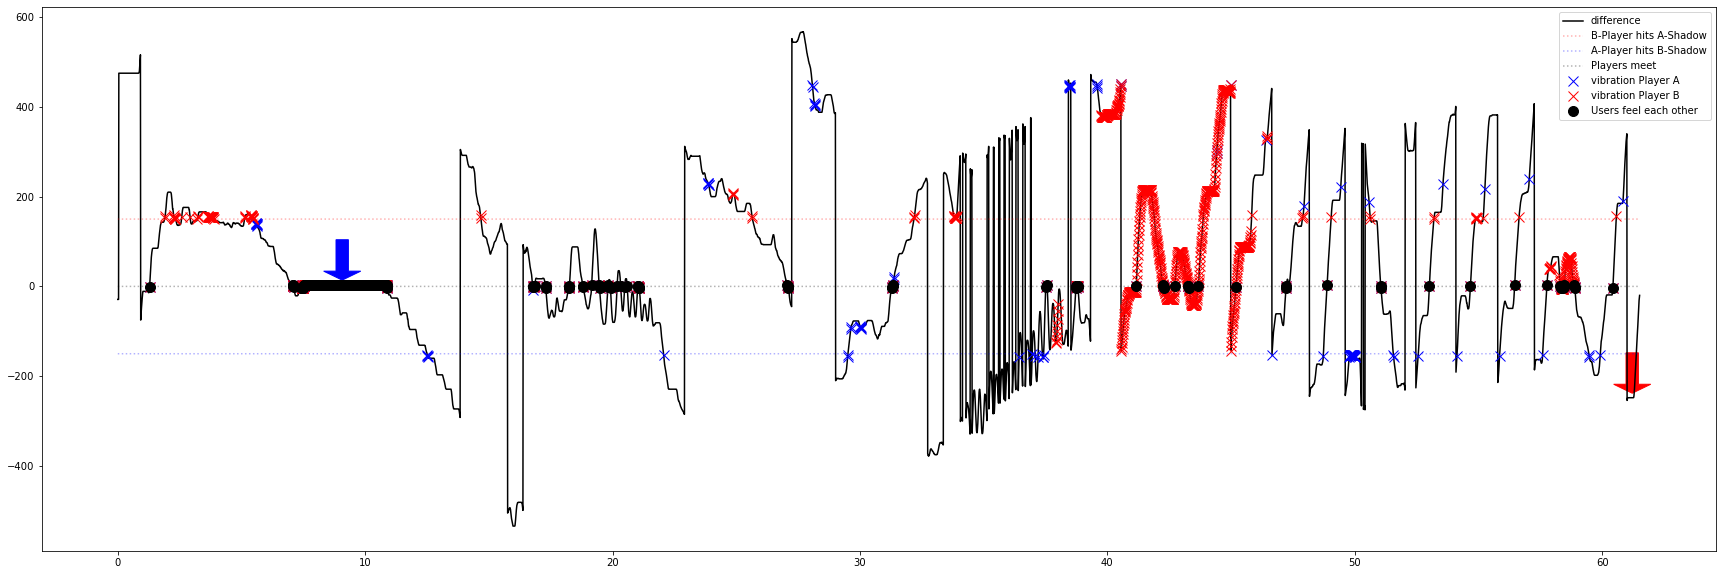

In [3]:
file = "Chicos\PCE_COMBINED_LOG 11,16,51 25-4-2018.csv"
array,df1,header_dict, column_list= load_file(r'C:\Users\david-bierbrauer\Documents\LabRotation\FroeseUnit\Teams\{}'.format(file))
plot_position(False,True,True,["A","B"])
plot_position(True,True,True,["A","B"])


# pandas whole dataset analysis
loading all files into a list of dataframes. then we can select the list by indexing
#### the main dataframe will be called df_current
##### df_click contains
PAS ratings

the time clicked

the actual object of interaction

collaboration assessment


In [4]:
# load all files in a list of dataframes
allfiles, df_list = load_files()

<ipython-input-2-f34f9691cedf>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["A-Tracker X"][0] = 0
<ipython-input-2-f34f9691cedf>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["B-Tracker X"][0] = 0
<ipython-input-2-f34f9691cedf>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["A-Acceleration"][0] = 0
<ipython-input-2-f34f9691cedf>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

# Transfer entropy

In [5]:
def df_TE(df):
    df_TE = df.copy()
    # binary series of haptic signals, make bool int combo to make it 1 and 0
    df_TE["A-hap"] = df_TE["A-Haptic 1"].astype("bool").astype("int") #maybe diff() for only the first
    df_TE["B-hap"] = df_TE["B-Haptic 1"].astype("bool").astype("int")
    # apply diff function to only get the first putton press (in raw data all entries after button press are 1)
    df_TE["A-button"] = df_TE["A-Buttonstate"].diff().astype("bool").astype("int")
    df_TE["B-button"] = df_TE["B-Buttonstate"].diff().astype("bool").astype("int")
    # diff function makes the first one true, we want them false to avoid more conditioning
    df_TE["A-button"][0] = 0
    df_TE["B-button"][0] = 0
    #that might help to kill the true otherwise if we don't want to manually set the first false
    #df_TE["B-button"][(df_TE["B-button"]==True) & (df_TE["System Time"]>0)]
    df_TE["A-turn"] = df_TE["A-Tracker X"]
    df_TE["A-turn"][df_TE["A-Tracker X"] > 0] = 1
    df_TE["A-turn"][df_TE["A-Tracker X"] < 0] = -1
    df_TE["A-diff"] = (0.5*(df_TE["A-turn"] + df_TE["A-turn"].diff()).fillna(0)).astype('int')
    
    df_TE["B-turn"] = df_TE["B-Tracker X"]
    df_TE["B-turn"][df_TE["B-Tracker X"] > 0] = 1
    df_TE["B-turn"][df_TE["B-Tracker X"] < 0] = -1
    df_TE["B-diff"] = (0.5*(df_TE["B-turn"] + df_TE["B-turn"].diff()).fillna(0)).astype('int')
    # binary acceleration
    df_TE["A-bin_acc"] = df_TE["A-Acceleration"]
    df_TE["A-bin_acc"][df_TE["A-Acceleration"] > 0] = 1
    df_TE["A-bin_acc"][df_TE["A-Acceleration"] < 0] = -1
    
    df_TE["B-bin_acc"] = df_TE["B-Acceleration"]
    df_TE["B-bin_acc"][df_TE["B-Acceleration"] > 0] = 1
    df_TE["B-bin_acc"][df_TE["B-Acceleration"] < 0] = -1
    #df_TE["B-turn"] = df_TE["B-Tracker X"].astype("bool").astype("int")
    return df_TE

df_binary_list = [df_TE(df) for df in df_list]

    

<ipython-input-5-601384f439f3>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TE["A-button"][0] = 0
<ipython-input-5-601384f439f3>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TE["B-button"][0] = 0
<ipython-input-5-601384f439f3>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TE["A-turn"][df_TE["A-Tracker X"] > 0] = 1
<ipython-input-5-601384f439f3>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [6]:
df_TE = df_binary_list[0]
df_TE["A-diff"] = (0.5*(df_TE["A-turn"] + df_TE["A-turn"].diff()).fillna(0)).astype('int')
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
#print(df_TE["A-diff"].values)
print(df_TE["A-turn"].values)
#print(df_TE["A-turn"].diff().fillna(0).astype('int').values)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1
  1  0  0  0  1  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  0  1  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1

In [7]:
# read the summary file about click time, PAS etc
df_PAS = pd.read_csv(r'C:\Users\david-bierbrauer\Documents\LabRotation\FroeseUnit\Teams\PAS.csv')
# extract the velocity columns from the dataframes and split up by players
P1_raw_velocity_list = [df["A-Tracker X"] for df in df_list]
P2_raw_velocity_list = [df["B-Tracker X"] for df in df_list]
raw_vel_list = P1_raw_velocity_list + P2_raw_velocity_list
# use binary form of velocity
P1_binary_velocity_list = [df["A-turn"] for df in df_binary_list]
P2_binary_velocity_list = [df["B-turn"] for df in df_binary_list]
binary_vel_list = P1_binary_velocity_list + P2_binary_velocity_list
# use binary onset form of velocity (only initial direction is noticed)
P1_binary_onset_velocity_list = [df["A-diff"] for df in df_binary_list]
P2_binary_onset_velocity_list = [df["B-diff"] for df in df_binary_list]
binary_onset_vel_list = P1_binary_onset_velocity_list + P2_binary_onset_velocity_list
# raw aceleration
P1_raw_acceleration_list = [df["A-Acceleration"] for df in df_list]
P2_raw_acceleration_list = [df["B-Acceleration"] for df in df_list]
raw_acc_list = P1_raw_acceleration_list + P2_raw_acceleration_list
# use binary form of acceleration
P1_binary_acceleration_list = [df["A-bin_acc"] for df in df_binary_list]
P2_binary_acceleration_list = [df["B-bin_acc"] for df in df_binary_list]
binary_acc_list = P1_binary_acceleration_list + P2_binary_acceleration_list




### get a list of haptic feedback
#static
P1_static_list = [df["UserA-Static"] for df in df_binary_list]
P2_static_list = [df["UserB-Static"] for df in df_binary_list]
static_list = P1_static_list + P2_static_list
# lure
P1_lure_list = [df["UserA-Lure"] for df in df_binary_list]
P2_lure_list = [df["UserB-Lure"] for df in df_binary_list]
lure_list = P1_lure_list + P2_lure_list
# users touching
P1_user_list = [df["Users Touching"] for df in df_binary_list]
P2_user_list = [df["Users Touching"] for df in df_binary_list]
user_list = P1_user_list + P2_user_list
# all haptic
P1_haptic_list = [df["A-hap"] for df in df_binary_list]
P2_haptic_list = [df["B-hap"] for df in df_binary_list]
haptic_list = P1_haptic_list + P2_haptic_list

dfs= static_list+lure_list+user_list+haptic_list
haptic_type=['static' for i in range(len(static_list))] + ['shadow' for i in range(len(lure_list))]+ ['player' for i in range(len(user_list))]+ ['all' for i in range(len(haptic_list))]
players = (['P1' for i in range(len(P1_static_list))]+['P2' for i in range(len(P2_static_list))])*4
dict_hap = {'df':dfs,'haptic_type':haptic_type,'Player':players}
df_haptics = pd.DataFrame(dict_hap)
print(df_haptics)







df_PAS['id'] = df_PAS.index
df_click = pd.wide_to_long(df_PAS,stubnames=['Col','Click','PAS','ClickTime'],i='id',j='Player',sep='_',suffix='\w+').sort_values(by=['Player','TeamID','Team','Trial']).reset_index()
# add lists to dataframe
df_click["raw_vel_series"] = raw_vel_list
print(df_click)
df_click["binary_vel_series"] = binary_vel_list
df_click["raw_acc_series"] = raw_acc_list

#example to see if everything is fine and to check the order in the dataframe
print(df_click['Col'][(df_click['Team']=='Belgas') & (df_click['Trial']==1)])

#print(df_click['Vel_series'].iloc[387])
# the function has the purpose of slice the time series according to the click time
# which series we put in is definable, as well as the number of seconds before the click
def dataset_local_slicing(seconds,P1_series_list,P2_series_list):
    # get all (even of NaN) click times in a list (just more convinient with following indexing)
    # the times are used to slice the provided time series
    ClickTimes_P1 = df_PAS["ClickTime_P1"].values/10
    ClickTimes_P2 = df_PAS["ClickTime_P2"].values/10
    # get indices of the files with actual clicks and store them in lists for each player
    clicks_index_P1 = df_PAS.index[df_PAS["ClickTime_P1"]>=1].tolist()
    clicks_index_P2 = df_PAS.index[df_PAS["ClickTime_P2"]>=1].tolist()
    # get (provided) series that have clicks -> P1_series_list[i]
    # now take these time series and slice with the values in clickTimes lists [int(ClickTimes_P1[i]-seconds*100):int(ClickTimes_P1[i])]
    # the max is to prevent negative indexing for early clicks
    # we need two lists, one for each player sliced by each players clicks
    # because we have to look at the past of both players for each click
    if seconds == 0:
        P1_sliced_byP1 = [P1_series_list[i] if i in clicks_index_P1 else np.nan for i in range(len(P1_series_list))]
        P2_sliced_byP1 = [P2_series_list[i] if i in clicks_index_P1 else np.nan for i in range(len(P1_series_list))]
        P1_sliced_byP2 = [P1_series_list[i] if i in clicks_index_P2 else np.nan for i in range(len(P1_series_list))]
        P2_sliced_byP2 = [P2_series_list[i] if i in clicks_index_P2 else np.nan for i in range(len(P1_series_list))]
    else:
        P1_sliced_byP1 = [P1_series_list[i][int(max(ClickTimes_P1[i]-seconds*100,0)):int(ClickTimes_P1[i])]
                                                    if i in clicks_index_P1 else np.nan for i in range(len(P1_series_list))]
        P2_sliced_byP1 = [P2_series_list[i][int(max(ClickTimes_P1[i]-seconds*100,0)):int(ClickTimes_P1[i])]
                                                    if i in clicks_index_P1 else np.nan for i in range(len(P1_series_list))]
        P1_sliced_byP2 = [P1_series_list[i][int(max(ClickTimes_P2[i]-seconds*100,0)):int(ClickTimes_P2[i])]
                                                    if i in clicks_index_P2 else np.nan for i in range(len(P1_series_list))]
        P2_sliced_byP2 = [P2_series_list[i][int(max(ClickTimes_P2[i]-seconds*100,0)):int(ClickTimes_P2[i])]
                                                    if i in clicks_index_P2 else np.nan for i in range(len(P1_series_list))]
    return P1_sliced_byP1, P2_sliced_byP2,P2_sliced_byP1,P1_sliced_byP2
    
    
def local_TE_dataframe(df1,k,lag):
    from PyIF import te_compute as te
    df = df1.copy()
    # compute self on other and other on self TE 
    # first values makes it an array (otherwise indexing is due to the previous infiltered dataframe),
    # the second values makes it a numpy array which is required for this method
    df["other_on_self"] = [te.te_compute(df["self_sliced"].values[i].values, df["other_sliced"].values[i].values, k=k, embedding=lag, safetyCheck=False, GPU=False)
                           if not isinstance(df["self_sliced"].values[i],float) else np.nan for i in range(len(df))]
    df["self_on_other"] = [te.te_compute(df["other_sliced"].values[i].values, df["self_sliced"].values[i].values, k=k, embedding=lag, safetyCheck=False, GPU=False)
                           if not isinstance(df["self_sliced"].values[i],float) else np.nan for i in range(len(df))]
    return df


def TE_Player_haptic(df1,k,lag):
    from PyIF import te_compute as te
    df = df1.copy()
    # compute self on other and other on self TE 
    # first values makes it an array (otherwise indexing is due to the previous infiltered dataframe),
    # the second values makes it a numpy array which is required for this method
    df["haptic_on_Player"] = [te.te_compute(df["Player_sliced"].values[i].values, df["haptic_sliced"].values[i].values, k=k, embedding=lag, safetyCheck=False, GPU=False)
                           if not isinstance(df["Player_sliced"].values[i],float) else np.nan for i in range(len(df))]
    df["Player_on_haptic"] = [te.te_compute(df["haptic_sliced"].values[i].values, df["Player_sliced"].values[i].values, k=k, embedding=lag, safetyCheck=False, GPU=False)
                           if not isinstance(df["Player_sliced"].values[i],float) else np.nan for i in range(len(df))]
    return df


                                                     df haptic_type Player
0     0       0
1       0
2       0
3       0
4     ...      static     P1
1     0       0
1       0
2       0
3       0
4     ...      static     P1
2     0       0
1       0
2       0
3       0
4     ...      static     P1
3     0       0
1       0
2       0
3       0
4     ...      static     P1
4     0       0
1       0
2       0
3       0
4     ...      static     P1
...                                                 ...         ...    ...
1547  0       0
1       0
2       0
3       0
4     ...         all     P2
1548  0       0
1       0
2       0
3       0
4     ...         all     P2
1549  0       0
1       0
2       0
3       0
4     ...         all     P2
1550  0       0
1       0
2       0
3       0
4     ...         all     P2
1551  0       0
1       0
2       0
3       0
4     ...         all     P2

[1552 rows x 3 columns]
      id Player  Trial  TeamID       Team  Col     Click  PAS  ClickTime  \

In [8]:
### set the slice lists
P1_list = P1_raw_acceleration_list #P1_binary_acceleration_list#P1_raw_velocity_list# #
P2_list = P2_raw_acceleration_list #P2_binary_acceleration_list#P2_raw_velocity_list# #
haptic_list = 

# slice
P1_sliced_byP1, P2_sliced_byP2,P2_sliced_byP1,P1_sliced_byP2 = dataset_local_slicing(5,P1_list,P2_list)
P_sliced_byP, H_sliced_byH,H_sliced_byP,P_sliced_byH = dataset_local_slicing(5,P1_list,P2_list)
df_click["self_sliced"] = P1_sliced_byP1 + P2_sliced_byP2
df_click["other_sliced"] = P2_sliced_byP1 + P1_sliced_byP2
df_click["Player_sliced"] = P_sliced_byP + H_sliced_byH
df_click["haptic_sliced"] = H_sliced_byP + P_sliced_byH
result1 = local_TE_dataframe(df_click,k=5,lag=10)
result5 = local_TE_dataframe(df_click,k=10,lag=5)
hapticresult1 = TE_Player_haptic(df_click,k=5,lag=10)
hapticresult5 = TE_Player_haptic(df_click,k=10,lag=5)

SyntaxError: invalid syntax (<ipython-input-8-ce9bb1eb74c9>, line 4)

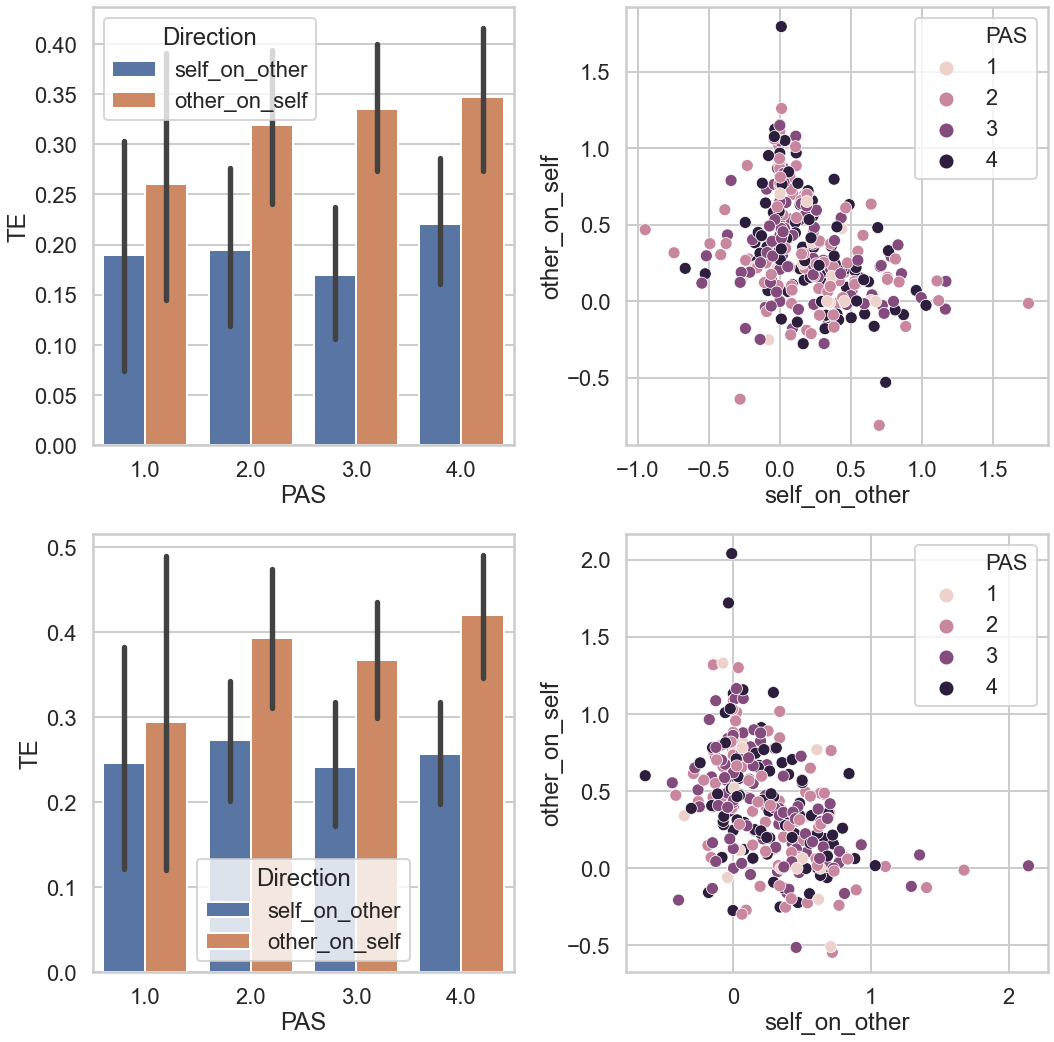

In [22]:
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("poster")
plt.figure(figsize=(15,15))
plt.subplot(2, 2, 1)
#result["ratio"] = result["other_on_self"]/result["self_on_other"]
interest = "PAS"
tidy1 = result1.melt(id_vars=['Player','Team','TeamID','Trial','Col','Click','PAS','ClickTime',"raw_vel_series","binary_vel_series","raw_acc_series",'self_sliced','other_sliced',"Player_sliced","haptic_sliced"],
                   value_vars=["self_on_other","other_on_self"],var_name= 'Direction',value_name='TE').sort_values(by=['TeamID','Team','Trial','Player'])
sns.barplot(x=interest, y='TE', hue='Direction', data=tidy1)

plt.subplot(2, 2, 2)
sns.scatterplot("self_on_other","other_on_self",hue=interest, data=result1)

plt.subplot(2, 2, 3)
tidy5 = result5.melt(id_vars=['Player','Team','TeamID','Trial','Col','Click','PAS','ClickTime',"raw_vel_series","binary_vel_series","raw_acc_series",'self_sliced','other_sliced',"Player_sliced","haptic_sliced"],
                   value_vars=["self_on_other","other_on_self"],var_name= 'Direction',value_name='TE').sort_values(by=['TeamID','Team','Trial','Player'])
sns.barplot(x=interest, y='TE', hue='Direction', data=tidy5)

plt.subplot(2, 2, 4)
sns.scatterplot("self_on_other","other_on_self",hue=interest, data=result5)
plt.tight_layout()

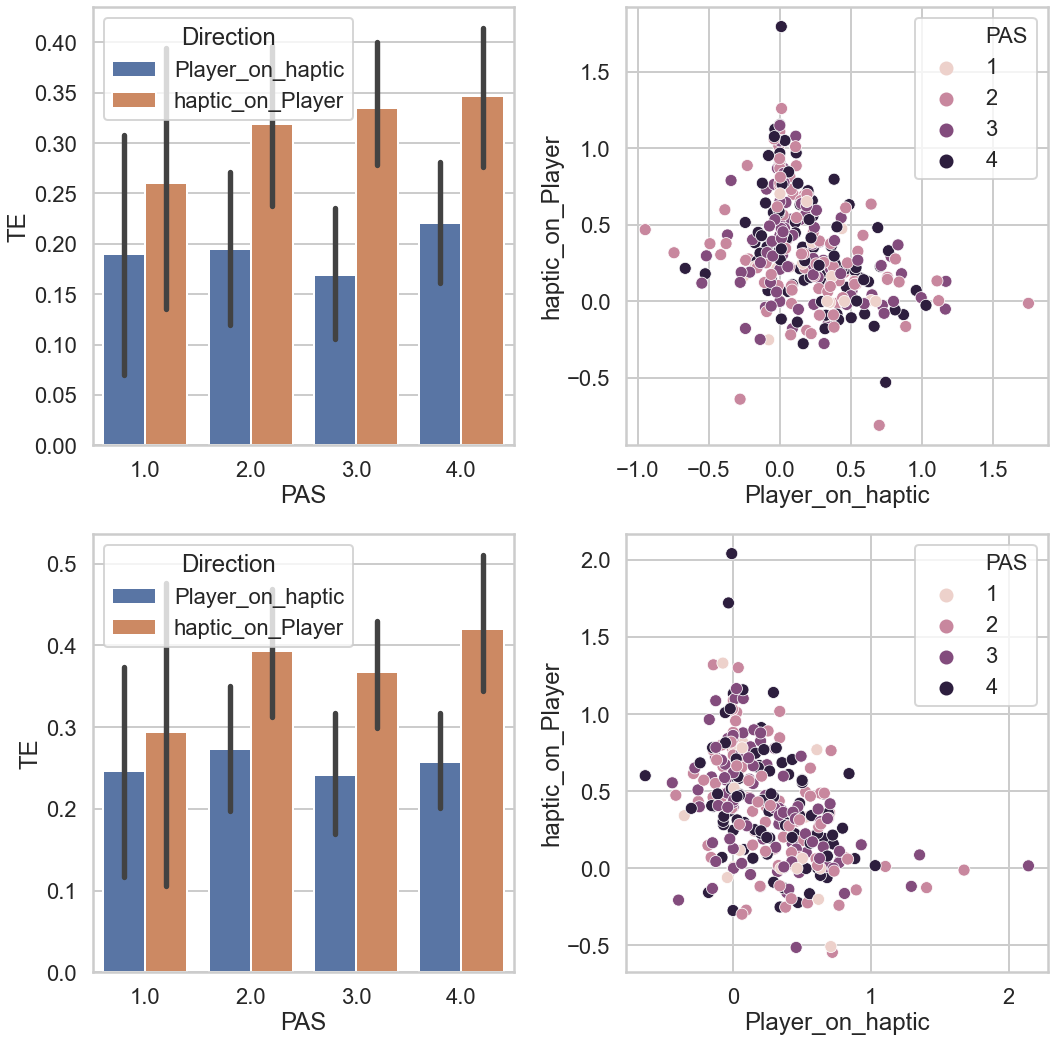

In [24]:
sns.set(style="whitegrid")
sns.set_context("poster")
plt.figure(figsize=(15,15))
plt.subplot(2, 2, 1)
#result["ratio"] = result["other_on_self"]/result["self_on_other"]
interest = "PAS"
haptictidy1 = hapticresult1.melt(id_vars=['Player','Team','TeamID','Trial','Col','Click','PAS','ClickTime',"raw_vel_series","binary_vel_series","raw_acc_series",'self_sliced','other_sliced',"Player_sliced","haptic_sliced"],
                   value_vars=["Player_on_haptic","haptic_on_Player"],var_name= 'Direction',value_name='TE').sort_values(by=['TeamID','Team','Trial','Player'])
sns.barplot(x=interest, y='TE', hue='Direction', data=haptictidy1)

plt.subplot(2, 2, 2)
sns.scatterplot("Player_on_haptic","haptic_on_Player",hue=interest, data=hapticresult1)

plt.subplot(2, 2, 3)
haptictidy5 = hapticresult5.melt(id_vars=['Player','Team','TeamID','Trial','Col','Click','PAS','ClickTime',"raw_vel_series","binary_vel_series","raw_acc_series",'self_sliced','other_sliced',"Player_sliced","haptic_sliced"],
                   value_vars=["Player_on_haptic","haptic_on_Player"],var_name= 'Direction',value_name='TE').sort_values(by=['TeamID','Team','Trial','Player'])
sns.barplot(x=interest, y='TE', hue='Direction', data=haptictidy5)

plt.subplot(2, 2, 4)
sns.scatterplot("Player_on_haptic","haptic_on_Player",hue=interest, data=hapticresult5)
plt.tight_layout()

In [ ]:
# choose the current dataframe from the list
df_current = df_list[7]


#upright plots
sns.set(style="white")
sns.set_context("talk")
fig, (ax, ax2,ax3) = plt.subplots(1, 3,figsize=(10,30))
ax.plot(df_current["A-Tracker X"],df_current["System Time"])
ax.plot(df_current["B-Tracker X"],df_current["System Time"])
sns.rugplot(df_current["System Time"][df_current["Users Touching"]>0],axis="y",color="black",height= 0.1,ax=ax,label="Users feel each other")
ax.set(ylim=(0,62))
ax2.plot(df_current["A-Acceleration"],df_current["System Time"])
ax2.plot(df_current["B-Acceleration"],df_current["System Time"])
sns.rugplot(df_current["System Time"][df_current["Users Touching"]>0],axis="y",color="black",height= 0.1,ax=ax2,label="Users feel each other")
ax2.set(ylim=(0,62))
ax3.plot(df_current["A-Position"],df_current["System Time"])
ax3.plot(df_current["B-Position"],df_current["System Time"])
sns.rugplot(df_current["System Time"][df_current["Users Touching"]>0],axis="y",color="black",height= 0.1,ax=ax3,label="Users feel each other")
ax3.set(ylim=(0,62))


# Correlation (single file)

In [ ]:
def pearson(*args):
    df1 = df[[arg for arg in args[0]]].copy()
    #df1 = df[["System Time","A-Position","B-Position","A-Tracker X","B-Tracker X"]].copy()
    overall_pearson_r = df1.corr()
    print(f"Pandas computed Pearson r: {overall_pearson_r}")
    # out: Pandas computed Pearson r: 0.2058774513561943

    r, p = stats.pearsonr(df1["A-Tracker X"], df1["B-Tracker X"])
    print(f"Scipy computed Pearson r: {r} and p-value: {p}")
    # out: Scipy computed Pearson r: 0.20587745135619354 and p-value: 3.7902989479463397e-51

def plot_pearson_vs_time(rolling_window,A,B):
    # Set window size to compute moving window synchrony.
    r_window_size = rolling_window
    f,ax=plt.subplots(3,1,figsize=(14,6),sharex=True)

    # position data
    df.plot("System Time",["A-Position","B-Position"],ax=ax[0])
    ax[0].set(xlabel='Time',ylabel='Position')

    # movement
    df.plot("System Time",[A,B],ax=ax[1])
    ax[1].set(xlabel='Time',ylabel='{},{}'.format(A,B))
    # pearson between movement
    df1 = df.copy()
    df1["Pearson r"] = df1[A].rolling(window=r_window_size, center=True).corr(df1[B].rolling(window=r_window_size, center=True))
    df1.plot("System Time","Pearson r",ax=ax[2])
    ax[2].set(xlabel='Time',ylabel='Pearson r')
    plt.suptitle("Position and rolling window correlation")

def crosscorr(datax, datay, lag=0, wrap=False):
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))
    
def windowed_time_lagged_cross_correlation(A,B):
    seconds = 1
    fps = 100
    no_splits = 20
    samples_per_split = df.shape[0]/no_splits
    rss=[]
    for t in range(0, no_splits):
        d1 = df[A].loc[(t)*samples_per_split:(t+1)*samples_per_split]
        d2 = df[B].loc[(t)*samples_per_split:(t+1)*samples_per_split]
        rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
        rss.append(rs)
    rss = pd.DataFrame(rss)
    f,ax = plt.subplots(figsize=(10,5))
    sns.heatmap(rss,cmap='RdBu_r',ax=ax)
    ax.set(title=f'Windowed Time Lagged Cross Correlation', xlabel='Offset',ylabel='Window epochs')
    
def rolling_window_time_lagged_cross_correlation(A,B):
    seconds = 1
    fps = 100
    window_size = 400 #samples
    t_start = 0
    t_end = t_start + window_size
    step_size = 50
    rss=[]
    while t_end < 6000:
        d1 = df[A].iloc[t_start:t_end]
        d2 = df[B].iloc[t_start:t_end]
        rs = [crosscorr(d1,d2, lag, wrap=False) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
        rss.append(rs)
        t_start = t_start + step_size
        t_end = t_end + step_size
    rss = pd.DataFrame(rss)
    rss = np.transpose(rss)
    f,ax = plt.subplots(figsize=(18,10))
    sns.heatmap(rss,cmap='RdBu_r',ax=ax)
    ax.set(title=f'Rolling Windowed Time Lagged Cross Correlation', xlabel='Time [s]',ylabel='Offset [ms]')
    ax.set_xticks([i for i in range(0,np.size(rss,1),5)])
    ax.set_xticklabels([i*step_size/fps for i in range(0,np.size(rss,1),5)])
    ax.set_yticks([i for i in range(0,int(2*seconds*fps+1),int(seconds*fps/10))])
    ax.set_yticklabels([i*10 for i in range(-int(seconds*fps),int(seconds*fps+1),int(seconds*fps/10))])

In [ ]:
#pearson(["System Time","A-Position","B-Position","A-Tracker X","B-Tracker X"])
#plot_pearson_vs_time(100,"A-Tracker X","B-Tracker X")
#windowed_time_lagged_cross_correlation("A-Tracker X","B-Tracker X")

rolling_window_time_lagged_cross_correlation("A-Tracker X","B-Tracker X")

# Turn taking
defining the turn taking as a binary event when the player changes direction. We use the Tracker columns

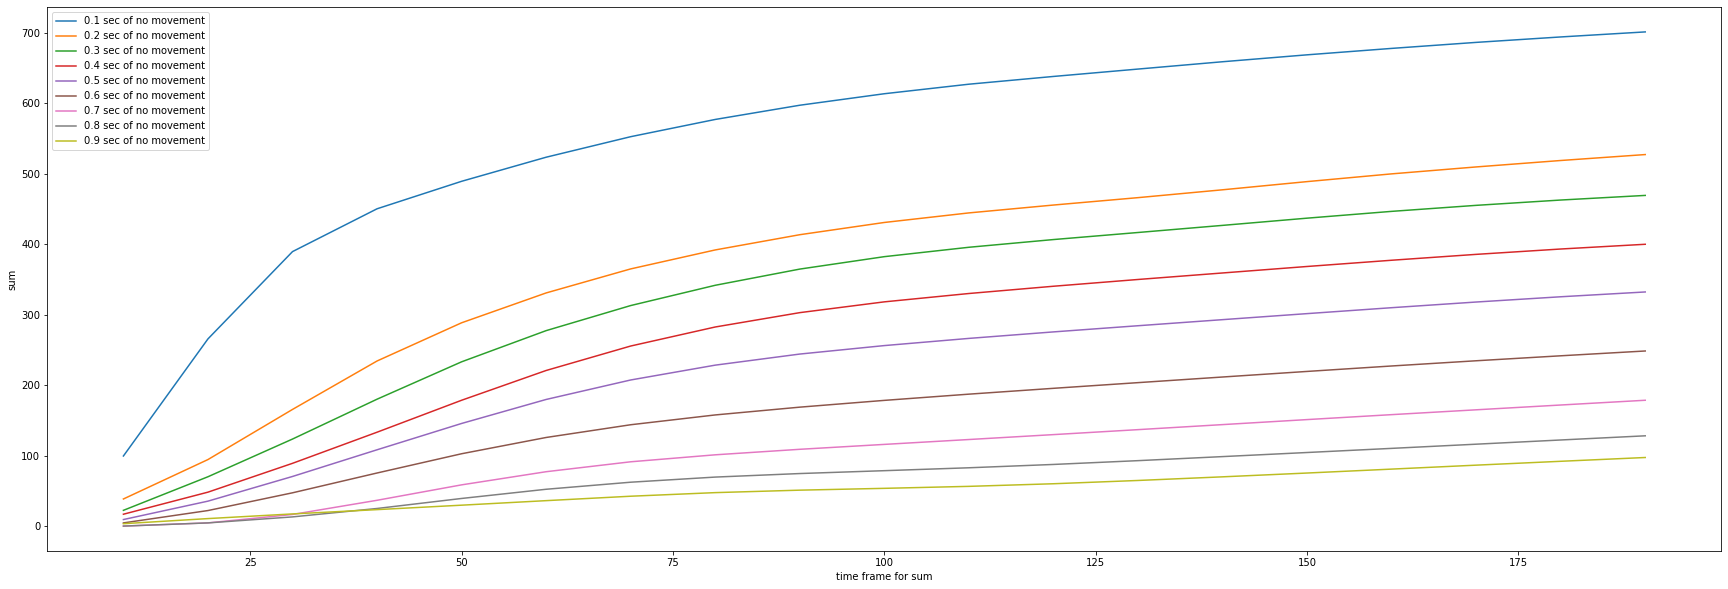

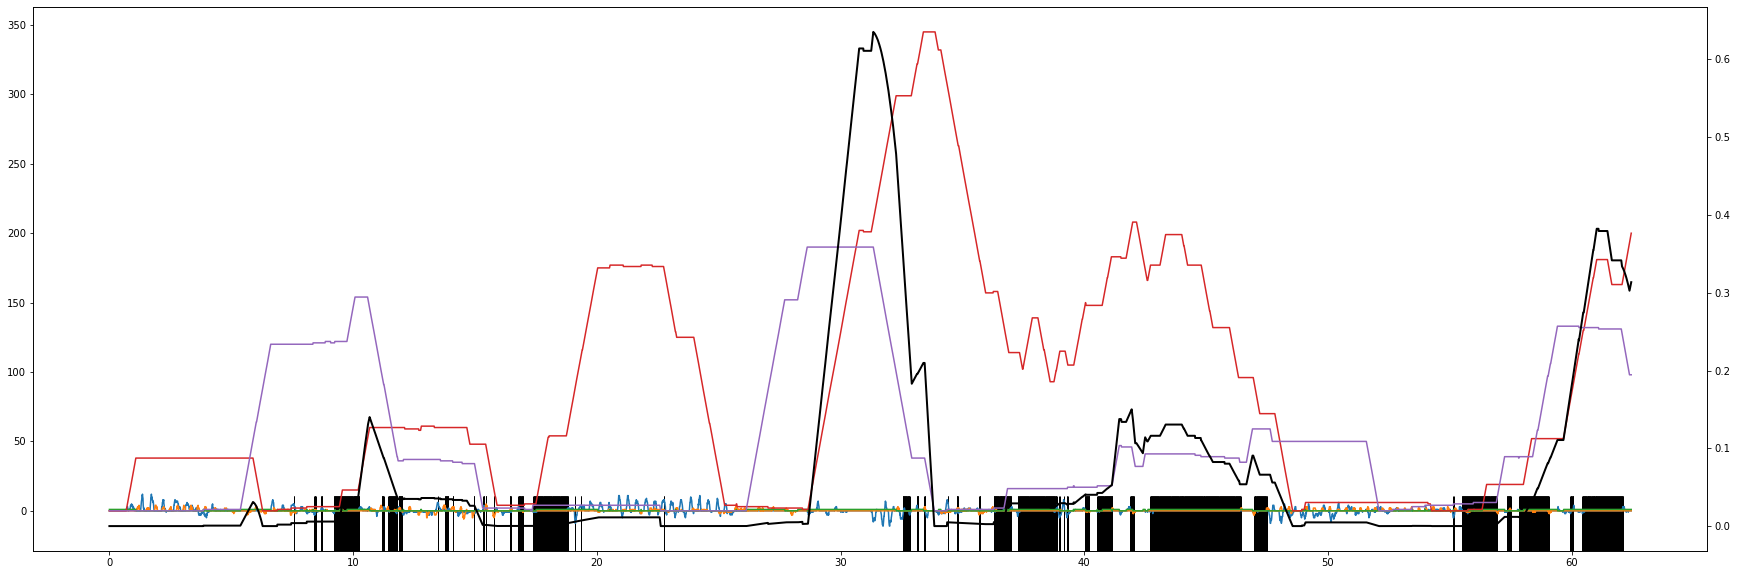

In [10]:
#from IPython.display import display
#pd.options.display.max_rows = None
#display(B1)
df = df_list[0]
def calc_TT(T0,T):
    df_tt = df.copy()
    # sum of movements over T0 steps,fill short windows with the current values (min_periods=1), make bool to consider them moving or not
    df_tt["A-turn"] = df_tt["A-Tracker X"].rolling(T0,min_periods=1).sum().astype("bool")
    df_tt["B-turn"] = df_tt["B-Tracker X"].rolling(T0,min_periods=1).sum().astype("bool")
    # difference in movement
    df_tt["D"] = ~(df_tt["A-turn"] & df_tt["B-turn"])
    # compare each movement to the difference and build the sum over the window T
    df_tt["C1"] = (df_tt["A-turn"] & df_tt["D"]).rolling(T,min_periods=1).sum()
    df_tt["C2"] = (df_tt["B-turn"] & df_tt["D"]).rolling(T,min_periods=1).sum()
    df_tt["TT"] = (4 * df_tt["C1"] * df_tt["C2"])/(T**2)
    return df_tt

def plot_sum():
    fig = plt.figure(figsize=(30,10))
    ax = fig.add_subplot(111)
    TT_sum_array = []
    T_array = [T for T in range(10,200,10)]
    T0_array = [T0 for T0 in range (10,100,10)]
    for T0 in T0_array:
        TT_sum_array=[]
        for T in T_array:
            df_tt = calc_TT(T0,T)
            TT_sum = df_tt["TT"].sum()
            TT_sum_array.append(TT_sum)
        ax.plot(T_array,TT_sum_array,label="{} sec of no movement".format(T0/100))
    ax.set(xlabel="time frame for sum",ylabel="sum")
    ax.legend()
   
    
def plot_time_series(T0,T):
    fig = plt.figure(figsize=(30,10))
    ax = fig.add_subplot(111)
    df_tt = calc_TT(T0,T)
    ax.plot(df_tt["System Time"],df_tt["A-Tracker X"])
    ax.plot(df_tt["System Time"],df_tt["B-Tracker X"])
    #ax.plot(df_tt["System Time"],df_tt["B-turn"])
    #ax.plot(df_tt["System Time"],df_tt["A-turn"])
    ax.plot(df_tt["System Time"],df_tt["D"])
    ax.plot(df_tt["System Time"],df_tt["C1"])
    ax.plot(df_tt["System Time"],df_tt["C2"])
    ax2= ax.twinx()
    ax2.plot(df_tt["System Time"],df_tt["TT"], color="black",linewidth=2)
    sns.rugplot(df_tt["System Time"][df_tt["Users Touching"]>0],color="black",height= 0.1,ax=ax,label="Users feel each other")
    
plot_sum()
plot_time_series(50,500)

# Transfer entropy

In [ ]:
df_current = df_list[0]
df_te = df_TE(df_current)
df_TE_analys = df_te[['A-turn','B-turn']].copy()
x=df_TE_analys['A-turn'].values
y=df_TE_analys['B-turn'].values
TE = te.te_compute(x,y, k=1, embedding=25, safetyCheck=False, GPU=False)

print(x)
print(y)
print(TE)

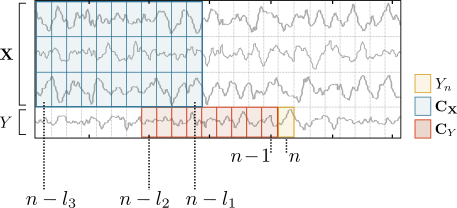

In [ ]:
# Import classes
from idtxl.bivariate_mi import BivariateMI
from idtxl.data import Data
from idtxl.visualise_graph import plot_network

# a) Generate test data
df_TE = df_TE(df_current)
df_TE_analys = df_TE[['A-turn','A-hap']].copy()
print(df_TE_analys)
    # pandas, this means that the rows are the samples (timesteps) and the columns are the processes (players)
    # and there is only one replication unless we will concatenate all daframes together (not done yet)
data = Data(df_TE_analys, dim_order='sp')

# b) Initialise analysis object and define settings
network_analysis = BivariateTE()  
settings = {'cmi_estimator': 'JidtGaussianCMI', #alternative'JidtKraskovCMI' nonlinear continuous
            'max_lag_sources': 1000, # max timesteps (L3) before target (n) seconds*100 (sample rate)
            'min_lag_sources': 1, # min timesteps (L1) before target 
            'max_lag_target': 1000} #targets own past
        

# c) Run analysis
#results = network_analysis.analyse_network(settings=settings, data=data)
results = network_analysis.analyse_single_target(settings=settings,
                                                 data=data,
                                                 target=0,
                                                 sources=[1])
#results = network_analysis.analyse_single_target(settings=settings,data=data,target=0) #maybe try this to define target and source
results.get_single_target(1, fdr=False)
# d) Plot inferred network to console and via matplotlib
results.print_edge_list(weights='max_te_lag', fdr=False)
plot_network(results=results, weights='max_te_lag', fdr=False)
plt.show()

# Whole dataset analysis

#### TODO
Transfer entropy, TT, Fourier analysis

In [ ]:
average = sum([df_list[i]["A-Tracker X"].mean() for i in range(len(df_list))])/len(df_list)
print(average)

In [ ]:
df_TE = df1.copy()
df_TE["B-turn"] = df_TE["B-Tracker X"]
df_TE["B-turn"][df_TE["B-Tracker X"] > 0] = 1
df_TE["B-turn"][df_TE["B-Tracker X"] < 0] = -1
for index, row in df_TE.iterrows():
    df_TE["B-turn"][df_TE["B-Tracker X"] == 0] = 

In [ ]:
from IPython.display import display
pd.options.display.max_rows = None
#display(B1)
print(df_TE["B-turn"])#[df_TE["A-hap"]==True])
